In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
from pyexplain.benchmark.file_utils import *
from pyexplain.benchmark.plot import *
from pyexplain.benchmark.check_results import *
from pyexplain.examples.utils import *

import IPython
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight']= 'bold'

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_result { max-width:85% !important; }</style>"))
# MAC
environment = 'MAC'
BASE_MAC_LINUX = {
    'MAC': '/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/',
    'LINUX': '/home/emilio/research/'
}

PATH_FIGURES_POST_PAPER = Path(BASE_MAC_LINUX[environment] + "01_holygrail/latex/journal/jair21/figures/")
OCUS_EXPLAIN_EXAMPLES = Path(BASE_MAC_LINUX[environment] + "05_OCUS_Explain/code/pyexplain/examples/")
EXPERIMENT_RESULTS = Path(BASE_MAC_LINUX[environment] + "06_HPC_Experiments/experiments/data/output/")
BASE_OUTPUT_PATH = BASE_MAC_LINUX[environment] + "06_HPC_Experiments/experiments/data/output/"
REMOTE_EXPERIMENT_RESULTS = "/data/brussel/101/vsc10143/hpc_experiments2/experiments/data/output/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
mapping_expl_config = {
    'OCUS': 'OCUS+Incr. HS',
    'OCUS_NOT_INCREMENTAL': 'OCUS',
    'OUS_INCREMENTAL_NAIVE': 'OUSb+Lit. Incr. HS',
    'OUS_INCREMENTAL_NAIVE_PARALLEL': 'OUS Iter.+Lit. Incr. HS',
    'OUS_NAIVE_PARALLEL': 'OUS Iter',
    'OUS_SS' : 'OUSb',
    'MUS': 'MUS'
}

In [20]:
sel_cols = [
    'cnf',
    'instance',
    'instance_dataset',
    'instance_family',
    'instance_type_x',
    'instance_type_y',
    'lits_derived',
    'lits_to_explain',
    'max_t_explain',
    'min_t_explain',
    'n_bij',
    'n_expls',
    'n_instances',
    'n_units',
    'n_units_to_check',
    'numbers_explained',
    'params_disable_disjoint_mcses',
    'params_explanation_computer',
    'puzzle_type',
    'time_cumul_explain',
    'time_explain',
    'time_timedout',
    'time_totalTime',
    'tot_lits_derived',
    'tot_time_explain',
    'total_expl_cost',
    "avg_expl_cost",
    "avg_diff_time_explain1",
    "avg_diff_time_explain2",
    "%lits_explained"
]

# 1. Extracting instance information 

In [21]:
df_instances_info = pd.read_pickle("/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/06_HPC_Experiments/jair/jair_instance_info.pkl")
display(df_instances_info)

,puzzle_type,instance_type,instance,cnf,lits_to_explain,n_instances,n_bij,n_units,n_units_to_check
0,demystify,sudoku,sudoku_sudokuwiki_19_3dmedusa-1.param.json,34155,729,1,10935,12447,10935
1,demystify,sudoku,sudoku_sudokuwiki_9_swordfish-1.param.json,34151,729,1,10935,12443,10935
2,demystify,skyscrapers,skyscrapers_skyscrapers_7_9-adv-tech-1.param.json,13754,125,1,762,889,762
3,demystify,skyscrapers,skyscrapers_skyscrapers_14_14-adv-tech-6.param...,13753,125,1,765,888,765
4,demystify,killersudoku,killersudoku_killersudoku_7_9-2-cage-unit-over...,3799138,729,1,1840716,1842841,1840716
...,...,...,...,...,...,...,...,...,...
398,logic,150,p18,8149,150,1,0,0,0
399,logic,150,p25,7102,150,1,0,0,0
400,logic,150,p20,7621,150,1,0,0,0
401,logic,150,p93,7772,150,1,0,0,0


In [22]:
df_mus = pd.read_pickle("/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/06_HPC_Experiments/jair/jair_rq2_mus.pkl")

In [23]:
df_all_grows = pd.read_pickle("/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/06_HPC_Experiments/jair/jair_rq2_all_grows.pkl")

df_all_grows["avg_expl_cost"] = df_all_grows.apply(
    lambda row: (row["total_expl_cost"]/row["n_expls"]) if row["n_expls"] > 0 else None, axis=1)

df_all_grows["diff_time_explain"] = df_all_grows.apply(
    lambda row: [t_expl - row["time_cumul_explain"][i-1] for i, t_expl in enumerate(row["time_cumul_explain"]) if i > 0], axis=1)

df_all_grows["avg_diff_time_explain1"] = df_all_grows.apply(
    lambda row: np.mean(row["diff_time_explain"]), axis=1)

df_all_grows["avg_diff_time_explain2"] = df_all_grows.apply(
    lambda row: np.mean(row["time_explain"]), axis=1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [24]:
df_all_grows_instances_info = pd.merge(
    df_all_grows, 
    df_instances_info, 
    how="inner", 
    left_on="params_instance", 
    right_on="instance")

df_all_grows_instances_info["%lits_explained"] = df_all_grows_instances_info.apply(
    lambda row: round(100 * row["tot_lits_derived"]/row["lits_to_explain"], 2), axis=1)


df_all_grows_timedout_instsances = df_all_grows_instances_info[
    (df_all_grows_instances_info["time_timedout"]) &
    (df_all_grows_instances_info["params_grow_config"] == "SUBSETMAX SAT MCSes + Actual + Unif.")

]

for col in sel_cols:
    if col == "time_timedout": continue
    display(df_all_grows_timedout_instsances[[col, "time_timedout"]].groupby(by="time_timedout").describe())
    

cnf                                                        \
               count          mean           std     min      25%      50%   
time_timedout                                                                
True           640.0  468658.79375  1.174524e+06  4572.0  34135.0  34143.0   

                                   
                   75%        max  
time_timedout                      
True           34152.0  3917591.0

instance         \
                 count unique   
time_timedout                   
True               640    160   

                                                                       
                                                             top freq  
time_timedout                                                          
True           sudoku_sudokuwiki_73_alignedpairexclusion-4.pa...    6

instance_dataset                       
                         count unique        top freq
time_timedout                                        
True                       640      2  DEMYSTIFY  623

instance_family                               
                        count unique                top freq
time_timedout                                               
True                      640     11  sudoku_sudokuwiki  456

instance_type_x                    
                        count unique     top freq
time_timedout                                    
True                      640      2  sudoku  534

instance_type_y                    
                        count unique     top freq
time_timedout                                    
True                      640     13  sudoku  456

lits_derived                
                     count unique top freq
time_timedout                             
True                   640    452  []  114

lits_to_explain                                              \
                        count        mean         std   min    25%    50%   
time_timedout                                                               
True                    640.0  651.976562  205.252799  64.0  729.0  729.0   

                             
                 75%    max  
time_timedout                
True           729.0  931.0

max_t_explain                                          \
                      count        mean        std  min         25%   
time_timedout                                                         
True                  640.0  467.675002  667.69658  0.0  109.620907   

                                                   
                      50%        75%          max  
time_timedout                                      
True           214.259922  535.64664  3530.164056

min_t_explain                                                    \
                      count        mean         std  min       25%        50%   
time_timedout                                                                   
True                  640.0  159.694119  523.972905  0.0  0.383648  34.683366   

                                       
                     75%          max  
time_timedout                          
True           74.356536  3530.164056

n_bij                                                       \
               count           mean            std  min      25%      50%   
time_timedout                                                               
True           640.0  220824.667187  570121.529286  0.0  10935.0  10935.0   

                                   
                   75%        max  
time_timedout                      
True           10935.0  1899801.0

n_expls                                                   
                count       mean        std  min  25%   50%   75%    max
time_timedout                                                           
True            640.0  36.051563  36.119331  0.0  6.0  25.0  60.0  179.0

n_instances                                   
                    count mean  std  min  25%  50%  75%  max
time_timedout                                               
True                640.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

n_units                                                        \
                count           mean            std  min       25%      50%   
time_timedout                                                                 
True            640.0  222209.379688  570438.264496  0.0  12425.75  12434.0   

                                   
                   75%        max  
time_timedout                      
True           12444.0  1901944.0

n_units_to_check                                              \
                         count           mean            std  min      25%   
time_timedout                                                                
True                     640.0  220824.667187  570121.529286  0.0  10935.0   

                                            
                   50%      75%        max  
time_timedout                               
True           10935.0  10935.0  1899801.0

numbers_explained                                             \
                          count        mean         std  min    25%    50%   
time_timedout                                                                
True                      640.0  288.489062  207.253709  0.0  49.75  357.5   

                             
                 75%    max  
time_timedout                
True           451.0  750.0

params_disable_disjoint_mcses                    
                                      count unique     top freq
time_timedout                                                  
True                                    640      1  ignore  640

params_explanation_computer                  
                                    count unique   top freq
time_timedout                                              
True                                  640      6  OCUS  158

puzzle_type                       
                    count unique        top freq
time_timedout                                   
True                  640      2  demystify  624

time_cumul_explain                
                           count unique top freq
time_timedout                                   
True                         640    527  []  114

time_explain                
                     count unique top freq
time_timedout                             
True                   640    527  []  114

time_totalTime                                               \
                       count    mean  std     min     25%     50%     75%   
time_timedout                                                               
True                   640.0  3600.0  0.0  3600.0  3600.0  3600.0  3600.0   

                       
                  max  
time_timedout          
True           3600.0

tot_lits_derived                                             \
                         count        mean         std  min    25%    50%   
time_timedout                                                               
True                     640.0  288.489062  207.253709  0.0  49.75  357.5   

                             
                 75%    max  
time_timedout                
True           451.0  750.0

tot_time_explain                                               \
                         count    mean  std     min     25%     50%     75%   
time_timedout                                                                 
True                     640.0  3600.0  0.0  3600.0  3600.0  3600.0  3600.0   

                       
                  max  
time_timedout          
True           3600.0

total_expl_cost                                            \
                        count        mean        std  min    25%    50%   
time_timedout                                                             
True                    640.0  811.417187  819.61698  0.0  106.0  568.0   

                               
                  75%     max  
time_timedout                  
True           1324.0  4493.0

avg_expl_cost                                              \
                      count       mean        std  min   25%        50%   
time_timedout                                                             
True                  526.0  23.580898  16.055669  1.0  20.0  20.655172   

                                      
                     75%         max  
time_timedout                         
True           20.811321  161.809524

avg_diff_time_explain1                                    \
                               count        mean         std       min   
time_timedout                                                            
True                           501.0  160.433338  246.044293  0.883701   

                                                              
                     25%        50%         75%          max  
time_timedout                                                 
True           41.289018  71.607836  185.449898  3275.971466

avg_diff_time_explain2                                    \
                               count        mean         std       min   
time_timedout                                                            
True                           526.0  268.887326  575.837523  0.849505   

                                                              
                     25%        50%         75%          max  
time_timedout                                                 
True           45.445746  86.055949  210.350516  3530.164056

%lits_explained                                            \
                        count       mean        std  min     25%    50%   
time_timedout                                                             
True                    640.0  44.488578  26.694844  0.0  27.815  52.13   

                             
                 75%    max  
time_timedout                
True           63.58  100.0

In [25]:
df_all_grows2 = pd.read_pickle("/Users/emiliogamba/Documents/01_VUB/01_Research/01_Shared_Projects/06_HPC_Experiments/jair/jair_rq2_all_grows_2023_06_27.pkl")



In [26]:
df_all_grows2["avg_expl_cost"] = df_all_grows2.apply(
    lambda row: (row["total_expl_cost"]/row["n_expls"]) if row["n_expls"] > 0 else None, axis=1)

df_all_grows2["diff_time_explain"] = df_all_grows2.apply(
    lambda row: [t_expl - row["time_cumul_explain"][i-1] for i, t_expl in enumerate(row["time_cumul_explain"]) if i > 0], axis=1)

df_all_grows2["avg_diff_time_explain1"] = df_all_grows2.apply(
    lambda row: None if len(row["diff_time_explain"]) == 0 else np.mean(row["diff_time_explain"]), axis=1)

df_all_grows2["avg_diff_time_explain2"] = df_all_grows2.apply(
    lambda row: None if len(row["time_explain"]) == 0 else np.mean(row["time_explain"]), axis=1)

# Loading results on explantaion generation

In [ ]:
df_all_grows_instances_info2 = pd.merge(
    df_all_grows2, 
    df_instances_info, 
    how="inner", 
    left_on="params_instance", 
    right_on="instance")

df_all_grows_instances_info2["%lits_explained"] = df_all_grows_instances_info2.apply(
    lambda row: round(100 * row["tot_lits_derived"]/row["lits_to_explain"], 2), axis=1)


df_all_grows_timedout_instances2 = df_all_grows_instances_info2[
    (df_all_grows_instances_info2["time_timedout"]) &
    (df_all_grows_instances_info2["params_grow_config"] == "SUBSETMAX SAT MCSes + Actual + Unif.")

]

#for col in sel_cols:
#    if col == "time_timedout": continue
#    display(df_all_grows_timedout_instances2[[col, "time_timedout"]].groupby(by="time_timedout").describe())
    

In [ ]:
# df_grouped = df_all_grows_instances_info2.groupby(by="time_timedout")
#for col in sel_cols:
#    if col == "time_timedout": continue
#    display(df_grouped[[col, "time_timedout"]].describe())
#    print(df_grouped[[col, "time_timedout"]].describe().to_latex(index=False))

In [ ]:
# df_grouped = df_all_grows_instances_info.groupby(by="time_timedout")
#for col in sel_cols:
#    if col == "time_timedout": continue
#    display(df_grouped[[col, "time_timedout"]].describe())
#print(df_grouped[[col, "time_timedout"]].describe().to_latex(index=False))

In [ ]:
## can we compute the average time to generate an explanation?
avg_expl_times = []
tot_list = []
for list_time_expl in df_all_grows_instances_info[
    (df_all_grows_instances_info["time_timedout"])
]["time_explain"].to_list():
    if len(list_time_expl) == 0:
        continue
        # avg_expl_times.append(3600)
    else:
        avg_expl_times.append(np.mean(list_time_expl))
    tot_list += list_time_expl
print(np.mean(avg_expl_times))
print(np.std(avg_expl_times))

print(np.mean(tot_list))
print(np.std(tot_list))

In [ ]:
df_all_grows_instances_info[
    
    (df_all_grows_instances_info["time_timedout"] ) & 
    (df_all_grows_instances_info["params_full_explanation_config"].isin([
        "OUSb+Iterative+Lit. Incr. HS+sort+DISJ_MCS",
        'MusX+SS. caching+sort',
        "OCUS+Incr. HS+sort+DISJ_MCS",
        "OUSb+Lit. Incr. HS+sort+DISJ_MCS"])
    ) &
    (df_all_grows_instances_info["tot_lits_derived"] == 0)
][
    ["params_full_explanation_config","params_instance", 'instance_family','instance_type_x', 'instance_type_y', "tot_lits_derived", "%lits_explained", "time_explain", "lits_to_explain"]
].groupby(by="params_full_explanation_config").count()

In [ ]:
df_all_grows_instances_info[
    (df_all_grows_instances_info["params_grow_config"] == "SUBSETMAX SAT MCSes + Actual + Unif.") &
    (df_all_grows_instances_info["params_full_explanation_config"] == "OUSb+Lit. Incr. HS+sort")
][['params_disable_disjoint_mcses',
 'params_disjoint_mcs_interpretation',
 'params_disjoint_mcs_weighing',
 'params_disjoint_mcses',
 'params_explanation_config',
 'params_interpretation',
 'params_maxsatpolarity',
 'params_reuse_SSes',
 'params_sort_literals',
 'params_weighing']]

In [ ]:
df_all_grows_instances_info2.columns.sort_values().to_list()

## Extracting table for timedout instances

In [ ]:
df_timedout_instances_config = df_all_grows_instances_info2[
    (df_all_grows_instances_info2["time_timedout"]) & 
    (df_all_grows_instances_info2["%lits_explained"] < 100) & 
    (df_all_grows_instances_info2["params_grow_config"] == "SUBSETMAX SAT MCSes + Actual + Unif.")
][
    ["params_full_explanation_config", "params_grow_config","params_instance", "%lits_explained", "instance_family", "instance_dataset"]
].groupby(by=[
    "params_full_explanation_config", 
    #"instance_dataset"
])["%lits_explained"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.95, 0.98, 1],
    #exclude=["mean", "std"]
).reset_index().sort_values(
    by="mean", 
    ascending=True)

display(df_timedout_instances_config)
display(df_timedout_instances_config.columns)

# COmputing the average time and the time to the first explanation

In [ ]:
df_timedout_corr_subset_instances_time_expl = df_all_grows_instances_info2[
    (df_all_grows_instances_info2["time_timedout"]) & 
    (df_all_grows_instances_info2["%lits_explained"] < 100) & 
    (df_all_grows_instances_info2["params_grow_config"] == "Greedy MCSes + Actual + Unif.")
][
    ["params_full_explanation_config", "params_explanation_config", "renamed_explanation_config", "params_instance", "time_explain"]
].reset_index(drop=True)

df_timedout_corr_subset_instances_time_expl["t1"] = df_timedout_corr_subset_instances_time_expl.apply(lambda row: None if len(row["time_explain"]) == 0 else row["time_explain"][0], axis=1)
df_timedout_corr_subset_instances_time_expl["texpl_avg"] = df_timedout_corr_subset_instances_time_expl.apply(lambda row: 3600 if len(row["time_explain"]) == 0 else np.mean(row["time_explain"] + [3600]), axis=1)

df_timedout_instances_time_expl_config = df_timedout_corr_subset_instances_time_expl.groupby(by="params_full_explanation_config").agg(
    avg_t1 = ("t1" , lambda x: f"${round(np.mean(x))} \\pm {round(np.std(x))}$"),
    cnt_no_expl=("time_explain", lambda x: f"[{sum(1 if (len(xi) == 0) else 0 for xi in x )} / {len(x)}]")
).reset_index()

display(df_timedout_instances_time_expl_config)

In [ ]:
[df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OCUS+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+Iterative+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OCUS+Incr. HS+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+Lit. Incr. HS+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+Iterative+Lit. Incr. HS+sort']["t1"].values ]

In [ ]:
plt.subplot(1,1 , 1)


In [ ]:
import seaborn as sns
fig, ax = plt.subplots()

# Create a plot
ax.violinplot(
    [df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OCUS+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+Iterative+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OCUS+Incr. HS+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+Lit. Incr. HS+sort']["t1"].values,
                           df_timedout_corr_subset_instances_time_expl[df_timedout_corr_subset_instances_time_expl["params_full_explanation_config"] == 'OUSb+Iterative+Lit. Incr. HS+sort']["t1"].values ]
)
ax.set_title('Violin Plot')
plt.show()


In [ ]:
df_timedout_corr_subset_instances_time_expl["params_explanation_config"].sort_values().unique().tolist()

In [ ]:
PATH_FIGURES_POST_PAPER

In [ ]:
fig, axs = plt.subplots(figsize=(9, 6))
b = sns.boxplot(
    ax=axs,
    data=df_timedout_corr_subset_instances_time_expl, 
    x="params_explanation_config", 
    y="t1",
    order=[
        'OCUS',
        'OUSb',
        'OUSb+Iterative',
        'OCUS+Incr. HS',
        'OUSb+Lit. Incr. HS',
        'OUSb+Iterative+Lit. Incr. HS'
    ]
)

axs.set_xticklabels([
    "OCUS", 
    "OCUS\_Bound", 
    "OCUS\_Split",
    "OCUS+Incr.", 
    "OCUS\_Bound+Incr.", 
    "OCUS\_Split+Incr.",
], rotation=30, fontsize=18, ha='right')

axs.yaxis.set_tick_params(labelsize = 20);
axs.set_xlabel(None)
axs.set_ylabel("Time (s)", fontsize = 22)
plt.savefig(PATH_FIGURES_POST_PAPER / "timedout_instances.pdf", bbox_inches='tight', transparent=True)
#plt.yscale('log')

[Text(1, 0, 'OCUS+Incr. HS+sort'),
 Text(2, 0, 'OCUS+sort'),
 Text(3, 0, 'OUSb+Iterative+Lit. Incr. HS+sort'),
 Text(4, 0, 'OUSb+Iterative+sort'),
 Text(5, 0, 'OUSb+Lit. Incr. HS+sort'),
 Text(6, 0, 'OUSb+sort')]

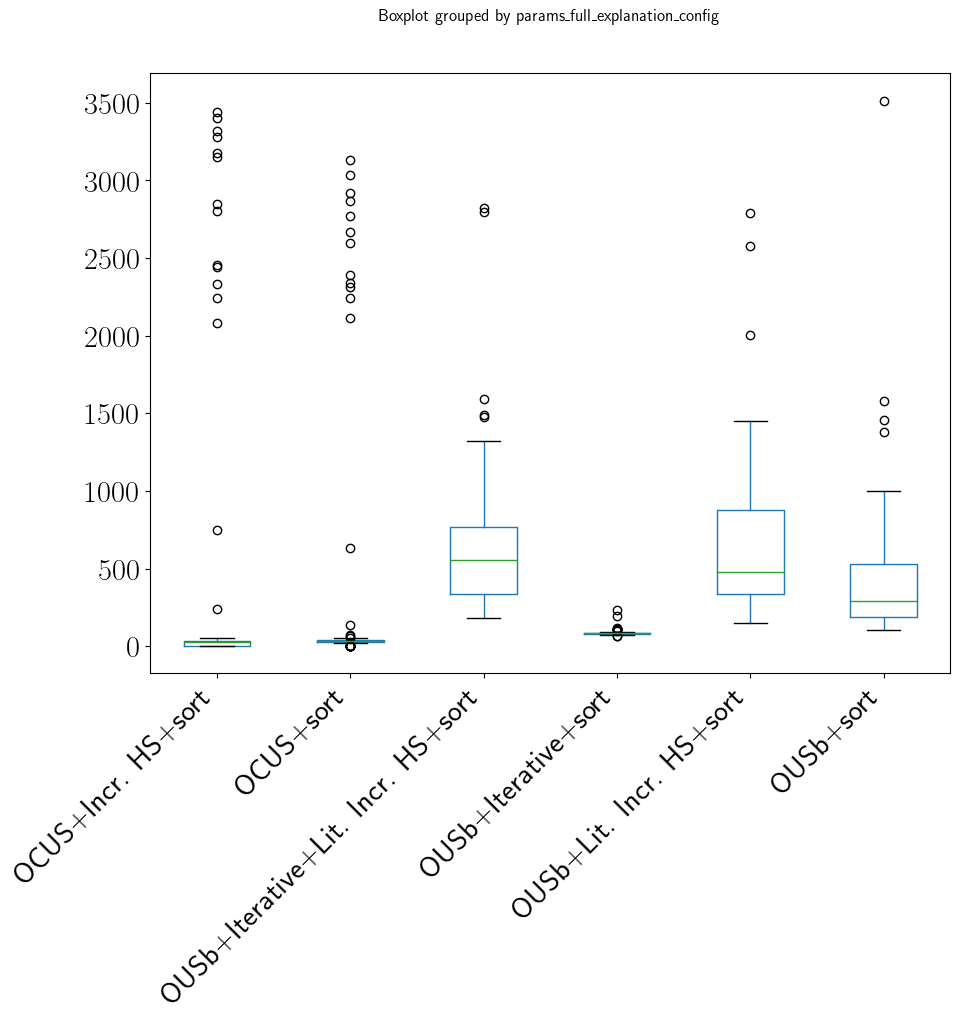

In [57]:
axs = df_timedout_corr_subset_instances_time_expl[
    ["t1", "params_full_explanation_config"]
].sort_values(
    by="params_full_explanation_config"
).boxplot(
    by="params_full_explanation_config", figsize=(10, 8), grid=False, fontsize=22)
axs.set_title(None)
axs.set_xlabel(None)
#ax.set_xticks(ax.get_xticks())
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')

<Axes: title={'center': 'texpl_avg'}, xlabel='[params_full_explanation_config]'>

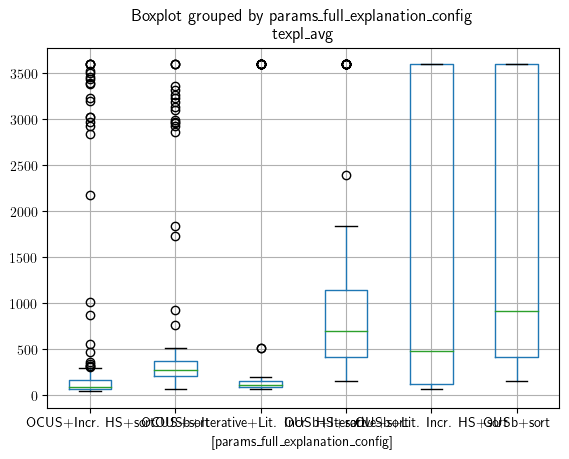

In [58]:
df_timedout_corr_subset_instances_time_expl[["texpl_avg", "params_full_explanation_config"]].boxplot(by="params_full_explanation_config")

In [160]:
df_all_grows_instances_info2[
    (df_all_grows_instances_info2["time_timedout"])&
        (df_all_grows_instances_info2["params_grow_config"] == "SUBSETMAX SAT MCSes + Actual + Unif.")

]["params_instance"].sort_values().unique()

array(['binairo_binairo_101_34.param.json',
       'binairo_binairo_103_12.param.json',
       'binairo_binairo_104_36.param.json',
       'binairo_binairo_112_13.param.json',
       'binairo_binairo_114_35.param.json',
       'binairo_binairo_117_50.param.json',
       'binairo_binairo_119_31.param.json',
       'binairo_binairo_121_33.param.json',
       'binairo_binairo_127_45.param.json',
       'binairo_binairo_130_24.param.json',
       'binairo_binairo_135_43.param.json',
       'binairo_binairo_146_23.param.json',
       'binairo_binairo_147_21.param.json',
       'binairo_binairo_150_40.param.json',
       'binairo_binairo_51_34.param.json',
       'binairo_binairo_52_10.param.json',
       'binairo_binairo_53_12.param.json',
       'binairo_binairo_54_36.param.json',
       'binairo_binairo_55_32.param.json',
       'binairo_binairo_56_16.param.json',
       'binairo_binairo_57_8.param.json',
       'binairo_binairo_58_14.param.json',
       'binairo_binairo_60_48.param.json'

## Merge table time to first expl, with % lits explained for all configurations

In [155]:
df_timedout_instances_info = pd.merge(
    left=df_timedout_instances_config,
    right=df_timedout_instances_time_expl_config,
    left_on="params_full_explanation_config",
    right_on="params_full_explanation_config")

for col in ['mean', '25%','50%','75%', '95%', '98%', '100%']:
    df_timedout_instances_info[col] = df_timedout_instances_info.apply(lambda row: round(row[col], 2), axis=1)
sel_cols = [
    #'std', 'params_grow_config', 'min', 'max', 
    'params_full_explanation_config', 'cnt_no_expl', 'avg_t1', 'mean', '25%','50%','75%', '95%', '98%', '100%']

display(df_timedout_instances_info[sel_cols])

print(df_timedout_instances_info[sel_cols].to_latex(index=False))

,params_full_explanation_config,cnt_no_expl,avg_t1,mean,25%,50%,75%,95%,98%,100%
0,OUSb+Lit. Incr. HS+sort,[44 / 93],$690 \pm 570$,31.98,0.00,37.86,62.14,76.65,79.16,86.56
1,OUSb+sort,[32 / 92],$454 \pm 516$,35.21,0.00,44.72,58.47,70.10,71.88,80.38
2,OUSb+Iterative+sort,[15 / 92],$88 \pm 23$,43.43,36.31,48.97,58.47,69.84,72.67,80.11
3,OCUS+sort,[3 / 111],$322 \pm 820$,44.57,34.64,51.03,60.31,73.12,78.24,86.01
4,OUSb+Iterative+Lit. Incr. HS+sort,[15 / 90],$653 \pm 484$,49.45,44.86,56.59,67.08,78.40,79.24,84.50
5,OCUS+Incr. HS+sort,[4 / 157],$265 \pm 800$,52.94,47.00,58.85,67.22,82.25,84.59,93.28


\begin{tabular}{lllrrrrrrr}
\toprule
   params\_full\_explanation\_config & cnt\_no\_expl &        avg\_t1 &  mean &   25\% &   50\% &   75\% &   95\% &   98\% &  100\% \\
\midrule
          OUSb+Lit. Incr. HS+sort &   [44 / 93] & \$690 \textbackslash pm 570\$ & 31.98 &  0.00 & 37.86 & 62.14 & 76.65 & 79.16 & 86.56 \\
                        OUSb+sort &   [32 / 92] & \$454 \textbackslash pm 516\$ & 35.21 &  0.00 & 44.72 & 58.47 & 70.10 & 71.88 & 80.38 \\
              OUSb+Iterative+sort &   [15 / 92] &   \$88 \textbackslash pm 23\$ & 43.43 & 36.31 & 48.97 & 58.47 & 69.84 & 72.67 & 80.11 \\
                        OCUS+sort &   [3 / 111] & \$322 \textbackslash pm 820\$ & 44.57 & 34.64 & 51.03 & 60.31 & 73.12 & 78.24 & 86.01 \\
OUSb+Iterative+Lit. Incr. HS+sort &   [15 / 90] & \$653 \textbackslash pm 484\$ & 49.45 & 44.86 & 56.59 & 67.08 & 78.40 & 79.24 & 84.50 \\
               OCUS+Incr. HS+sort &   [4 / 157] & \$265 \textbackslash pm 800\$ & 52.94 & 47.00 & 58.85 & 67.22 & 82.25 & 84

/var/folders/7x/w1gprqxx2xx6tk7j178kv9hr0000gp/T/ipykernel_32249/1857444929.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_timedout_instances_info[sel_cols].to_latex(index=False))


In [156]:
df_all_grows_instances_info2[
        (df_all_grows_instances_info2["time_timedout"]) & 
    (df_all_grows_instances_info2["params_full_explanation_config"] == "MusX+SS. caching+sort")][["params_instance", "time_timedout", "tot_lits_derived", "lits_to_explain", "%lits_explained"]]

,params_instance,time_timedout,tot_lits_derived,lits_to_explain,%lits_explained
7981,sudoku_sudokuwiki_59_uniquerectangles-11.param...,True,289,729,39.64
8021,sudoku_sudokuwiki_33_hiddenuniqrectangles-1.pa...,True,480,729,65.84
8061,sudoku_sudokuwiki_52_hiddenquads-1.param.json,True,406,729,55.69
8101,sudoku_sudokuwiki_60_uniquerectangles-9.param....,True,505,729,69.27
8141,sudoku_sudokuwiki_24_hiddensingles.param.json,True,263,729,36.08
8181,sudoku_sudokuwiki_45_xcycles.param.json,True,591,729,81.07
8221,sudoku_sudokuwiki_25_BUG-2.param.json,True,468,729,64.20
8261,sudoku_sudokuwiki_32_hiddenuniqrectangles-3.pa...,True,404,729,55.42
8301,sudoku_sudokuwiki_8_wxyzwing-3.param.json,True,249,729,34.16
8341,sudoku_sudokuwiki_10_perfect333swordfish.param...,True,451,729,61.87
